# 23/01/2024 - Hand Gesture Recognition

---


# Setup


## Install Dependencies


In [19]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Import libraries


In [20]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import time
import os

In [21]:
tf.get_logger().setLevel("ERROR")

In [22]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 6851), started 0:01:04 ago. (Use '!kill 6851' to kill it.)

# Data Preprocessing


In [24]:
DATASET_PATH = "./datasets/distance_and_angles_gestures_dataset.csv"

### Read CSV and split inputs from labels


In [25]:
from helpers.data import write_labels

dataset = pd.read_csv(DATASET_PATH)

print("is any NA in dataset ?", dataset.isna().any().any())
print("is any null in dataset ?", dataset.isnull().any().any())


labels = dataset["label"]
inputs = dataset.drop("label", axis=1)


inputs = inputs.to_numpy()
inputs = inputs.astype("float32")

X = inputs

dummies = pd.get_dummies(
    labels
)  # Creates a df of labels as categorical (ex : "closed" = [1, 0, 0, ..., 0])

classes = dummies.columns.to_list()
write_labels("./", classes)

labels = dummies.to_numpy()
labels = labels.astype("int64")


print(f"Input shape : {X[0].shape}")
print(f"Output shape : {labels[0].shape}")

is any NA in dataset ? False
is any null in dataset ? False
Input shape : (42,)
Output shape : (8,)


In [26]:
labels.shape

(93304, 8)

### Split data into training and testing sets


In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42
)
print(f"Total dataset size : {len(X)}")
print("====================================")

print(f"Train dataset size : {len(x_train)}")
print(f"Test dataset size : {len(x_test)}")

Total dataset size : 93304
Train dataset size : 74643
Test dataset size : 18661


In [28]:
input_shape = X.shape[1]
output_shape = len(classes)
print(f"Input is of shape : {input_shape}")
print(f"Output is of shape : {output_shape}")

Input is of shape : 42
Output is of shape : 8


# Create the model


In [29]:
LOAD_MODEL = False
MODEL_LOAD_PATH = "./models"

LEARNING_RATE = 0.001
REGULARIZATION_RATE = 0.001
DROPOUT = 0.5

In [30]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

from helpers.misc import get_model_name

model_name = ""


if LOAD_MODEL:
    model_name = MODEL_LOAD_PATH.split("/")[-1].split(".")[0]
    model = load_model(MODEL_LOAD_PATH)

else:
    model_name = get_model_name()

    regularizer = regularizers.l2(REGULARIZATION_RATE)

    model = Sequential(
        [
            Input(shape=[input_shape]),
            #
            Dense(32, activation="relu", kernel_regularizer=regularizer),
            # BatchNormalization(),
            # Dropout(rate=DROPOUT),
            #
            Dense(16, activation="relu", kernel_regularizer=regularizer),
            # BatchNormalization(),
            # Dropout(rate=DROPOUT),
            #
            Dense(units=output_shape, activation="softmax"),
        ]
    )

    optimizer = Adam(learning_rate=LEARNING_RATE)

    checkpointer_callback = ModelCheckpoint(
        filepath=f"models/{model_name}/{model_name}.hdf5",
        monitor="val_loss",
        verbose=False,
        save_best_only=True,
    )

    model.summary()

    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1376      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 2040 (7.97 KB)
Trainable params: 2040 (7.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=20
)

In [32]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = (
    "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + " - " + model_name
)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [33]:
MODEL_METRICS_PATH = f"./models/{model_name}/training.log"

In [34]:
from tensorflow.keras.callbacks import CSVLogger

csv_logger_callback = CSVLogger(MODEL_METRICS_PATH, separator=",", append=True)

In [35]:
os.makedirs(f"./models/{model_name}", exist_ok=True)

# Model Training


### Hyperparameters


In [36]:
SAVE_MODEL_PATH = f"./models/{model_name}"
LOAD_MODEL = False

NUM_EPOCHS = 1000

VALIDATION_SPLIT = 0.2

BATCH_SIZE = 32
VERBOSE = 2

In [37]:
print(X.shape)
print(labels.shape)

(93304, 42)
(93304, 8)


In [38]:
from helpers.misc import get_timestamp

print(f"Training model {model_name}...\n")
start_time = time.time()


history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_split=VALIDATION_SPLIT,
    verbose=VERBOSE,
    callbacks=[
        checkpointer_callback,
        csv_logger_callback,
        # early_stopping_callback,
        tensorboard_callback,
    ],
)


training_duration = get_timestamp(time.time() - start_time)

print("\n-------------\n")
print("Training complete!")
print(f"Completed training in {training_duration}")

Training model tfint64...

Epoch 1/1000
1867/1867 - 1s - loss: 1.2348 - accuracy: 0.6339 - val_loss: 0.7854 - val_accuracy: 0.8449 - 1s/epoch - 764us/step
Epoch 2/1000


/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1867/1867 - 1s - loss: 0.7097 - accuracy: 0.8527 - val_loss: 0.6491 - val_accuracy: 0.8739 - 889ms/epoch - 476us/step
Epoch 3/1000
1867/1867 - 1s - loss: 0.6465 - accuracy: 0.8683 - val_loss: 0.6044 - val_accuracy: 0.8784 - 887ms/epoch - 475us/step
Epoch 4/1000
1867/1867 - 1s - loss: 0.6125 - accuracy: 0.8749 - val_loss: 0.5751 - val_accuracy: 0.8816 - 877ms/epoch - 470us/step
Epoch 5/1000
1867/1867 - 1s - loss: 0.5894 - accuracy: 0.8813 - val_loss: 0.5599 - val_accuracy: 0.8913 - 930ms/epoch - 498us/step
Epoch 6/1000
1867/1867 - 1s - loss: 0.5700 - accuracy: 0.8875 - val_loss: 0.5437 - val_accuracy: 0.8828 - 893ms/epoch - 478us/step
Epoch 7/1000
1867/1867 - 1s - loss: 0.5536 - accuracy: 0.8917 - val_loss: 0.5172 - val_accuracy: 0.9026 - 877ms/epoch - 470us/step
Epoch 8/1000
1867/1867 - 1s - loss: 0.5378 - accuracy: 0.8964 - val_loss: 0.4999 - val_accuracy: 0.9066 - 896ms/epoch - 480us/step
Epoch 9/1000
1867/1867 - 1s - loss: 0.5210 - accuracy: 0.9004 - val_loss: 0.5054 - val_accuracy:

InvalidArgumentError: Graph execution error:

Detected at node Equal defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/traitlets/config/application.py", line 1077, in launch_instance

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 529, in dispatch_queue

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 518, in process_one

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 424, in dispatch_shell

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/folders/85/04dxvd3x7wsbz88m2jf0z4000000gn/T/ipykernel_6838/4021661721.py", line 8, in <module>

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/engine/training.py", line 1856, in fit

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/engine/training.py", line 1920, in test_step

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/engine/training.py", line 1249, in compute_metrics

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 620, in update_state

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/metrics/accuracy_metrics.py", line 426, in categorical_accuracy

  File "/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 969, in sparse_categorical_matches

Expected tensor of type int64 but got type float
	 [[{{node Equal}}]] [Op:__inference_test_function_8759]

## Display model training metrics


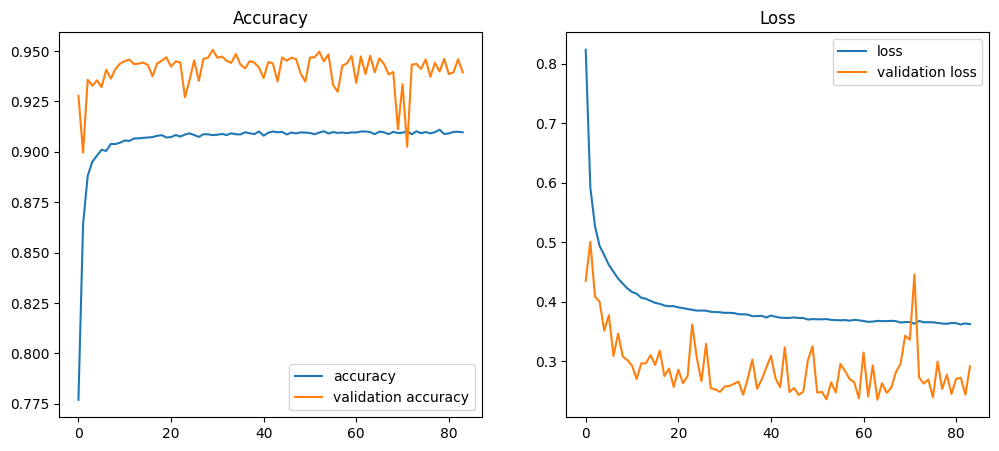

In [ ]:
metrics = pd.read_csv(MODEL_METRICS_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(metrics["accuracy"], label="accuracy")
ax1.plot(metrics["val_accuracy"], label="validation accuracy")
ax1.set_title("Accuracy")

ax2.plot(metrics["loss"], label="loss")
ax2.plot(metrics["val_loss"], label="validation loss")
ax2.set_title("Loss")

ax1.legend()
ax2.legend()
plt.show()

## Evaluate the model


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=VERBOSE)


print("\n")
print(f"Perte (Loss) sur l'ensemble de test : {loss}")
print(f"Précision (Accuracy) sur l'ensemble de test : {accuracy}")

584/584 - 0s - loss: 0.3646 - accuracy: 0.9123 - 262ms/epoch - 448us/step


Perte (Loss) sur l'ensemble de test : 0.364562451839447
Précision (Accuracy) sur l'ensemble de test : 0.9122769236564636
